In [1]:
%pylab inline

from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


Расчет резонатора и необходимых линз для согласования входного пучка.
Параметры зеркал в резонаторе и другие необходимые переменные

In [2]:
r = 40e-3 # curvature of sferical mirrors
l_sp = 80e-3 # distance from sferical to plane mirror
l_pp = 156e-3 - l_sp # distance between to plane mirrors
l_ss = 46e-3 # distance between to curved mirrors
λ = 0.82e-6 


pos = 0.5 # distance from lenz to input mirror
f = pos + l_pp/2   # first gess for focal length of the mirror
q0 = 0
def apply_m_to_q(m,q):
    return (m[0,0]*q + m[0,1]) / (m[1,0]*q + m[1,1])
def m_l(l):
    return array([[1,l],[0,1]])
def m_f(f):
    return array([[1,0],[-1/f,1]])
def get_w(q):
    return sqrt(λ / (pi * imag(-1/q)))
def get_w0(q):
    return sqrt(λ / pi * imag(q))

Запишем обход резонатора, начиная с центра кристалла, т.е. с середины между сферичискими зеркалами

In [3]:
ring = dot(m_l(l_ss/2),
          dot(m_f(r/2),
              dot(m_l(l_sp + l_pp + l_sp),
                 dot(m_f(r/2),m_l(l_ss/2)))))

Находим графически решение уравнения - не стал заморачиваться с формулой

q0 =  0.001j
w0 =  1.6155931006e-05


<function __main__.plot0>

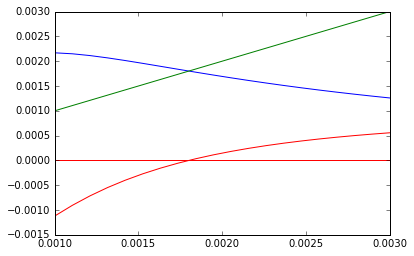

In [4]:
x = 1j * linspace(0.001, 0.003,20)
y = apply_m_to_q(ring,x)
def plot0(x0=imag(q0)):
    plot(imag(x),real(y),'r')
    axhline(0,c='r')
    plot(imag(x),imag(y))
    axvline(x0,c='k')
    plot(imag(x),imag(x))
    global q0, w0
    q0 = 1j*x0
    print('q0 = ',q0)
    w0 = get_w0(q0)
    print('w0 = ',w0)
interact(plot0,x0=(0.001,0.003,0.00005))


Найдем размер перетяжки и параметр q посередине между плоскими зеркалами

In [5]:
half_ring = dot(m_l(l_sp + l_pp/2),
                  dot(m_f(r/2),m_l(l_ss/2)))

In [6]:
q1 = apply_m_to_q(half_ring, 1j*0.0018)
print('q1 between to lpane mirrors = ', q1)
w1 = get_w0(q1)
print('w1 = ',w1)

q1 between to lpane mirrors =  (-3.92156862745e-05+0.0588235294118j)
w1 =  0.000123910334438


Строим зависимость параметра q и размера пучка от расстояния от перетяжки

In [7]:
xs = l_pp/2 + linspace(0,1,100)
qs = [apply_m_to_q(m_l(x), q1) for x in xs]
ws = [get_w(q) for q in qs]

In [8]:
def waist(z, w0):
    return w0*(1 + (z/(pi*w0**2/λ))**2)**(1/2)

Здесь подгоняю параметры пучка выходящего из лазера, чтобы совпадало с измеренными 0.55, 0.68, 0.9

In [9]:
waist(array([0.4,1.25,2]) - 0.4,0.55e-3) * 1e3

array([ 0.55      ,  0.68207024,  0.93758061])

Находим пересечение профилей пучков для резонатора и лазера. В этом месте должна стоять линза. В верней страке задается расстояние между входом в резонатор и выходом из лазера

focal length =  0.35 m


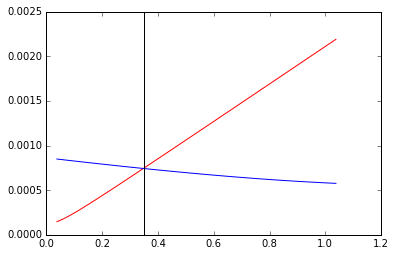

In [10]:
wls = waist(1.4-xs,0.55e-3)
def plot1(x0=f):
    global pos, f
    plot(xs, ws,c='r')
    plot(xs, wls,c='b')
    axvline(x0,c='k')
    f = x0
    pos = x0 - l_pp/2
    print('focal length = ', f, 'm')
interact(plot1, x0=(0,1,0.01))


То же самое, но выходящий пучок из лазера считается плоскопараллельным с заданным диаметром.

focal length =  0.42 m


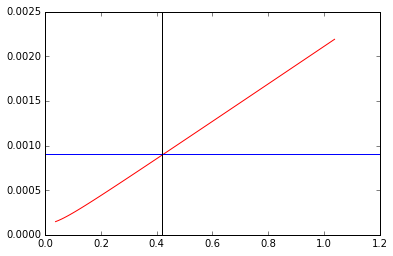

In [11]:
w_laser = 0.9e-3
def plot1(x0=f):
    global pos, f
    plot(xs, ws,'r')
    axhline(w_laser,c='b')
    axvline(x0,c='k')
    f = x0
    pos = x0 - l_pp/2
    print('focal length = ', f, 'm')
interact(plot1, x0=(0,1,0.01))

### Выводы

Нужна согласующая линза с фокусным расстоянием 30 - 40 см (в зависимости от того, какое выберем расстояние от лазера до удвоителя) и дополнительно телескопическая система с единичным увеличением для более тонкой юстировки.

Либо любая линза и телескопическая система с соответствующим увеличением

Дальше пытался использовать символы

In [195]:
import sympy as sp

In [201]:
f1, f2, d, s = sp.symbols('f1 f2 d s')

In [202]:
mt = dot(m_l(s),
        dot(m_f(f2),
            dot(m_l(d),m_f(f1))))
mt

array([[-d/f1 + s*(-(-d/f1 + 1)/f2 - 1/f1) + 1, d + s*(-d/f2 + 1)],
       [-(-d/f1 + 1)/f2 - 1/f1, -d/f2 + 1]], dtype=object)

In [203]:
dot([[1,2],[3,4]],[1,2])

array([ 5, 11])

In [204]:
dot(mt,[1,0])

array([-d/f1 + s*(-(-d/f1 + 1)/f2 - 1/f1) + 1, -(-d/f1 + 1)/f2 - 1/f1], dtype=object)

Некоторые вычисления

In [11]:
def finesse (R,A):
#     R - input mirror reflectivity, A - losses in the cavity
    return pi/(1 - sqrt(R*(1-A)))

In [33]:
finesse(0.99,0.005)

418.70324218042771

In [14]:
from scipy.optimize import root`

In [38]:
R = 0.99
root(lambda A: finesse(R,A)-370,0)

    fjac: array([[-1.]])
     fun: array([  1.13686838e-13])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([ -8.50082529e-08])
       r: array([ 21755.1706625])
  status: 1
 success: True
       x: array([ 0.00697928])

In [37]:
8500/23

369.5652173913044